In [1]:
import numpy as np
import math
import gzip
import random
import time
import bisect

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)
print('ok')

ok


In [2]:
users=[]
bussiness=[]
for l in readGz("data/train.json.gz"):
    u=l['userID']
    b=l['businessID']
    users.append(u)
    bussiness.append(b)
    
user_set=set(users)
buss_set=set(bussiness)

Nu=len(user_set)  # 18793
Nb=len(buss_set)  # 21321

user_index={}
buss_index={}

for (i,u) in enumerate(user_set):
    user_index[u]=i
for (i,b) in enumerate(buss_set):
    buss_index[b]=i
print(Nu,Nb)
print('ok')

18793 21321
ok


In [3]:
num_train=199000

user_business={}

ui_val=[]
bi_val=[]
y_val=[]

i=0
for l in readGz("data/train.json.gz"):
    u=user_index[l['userID']]
    b=buss_index[l['businessID']]
    if i<num_train:
        if u in user_business:
            user_business[u].append(b)
        else:
            user_business[u]=[b]
    else:
        ui_val.append(u)
        bi_val.append(b)
        y_val.append(1)
    i+=1
print('ok')

ok


In [4]:
for (u,b_list) in user_business.items():
    user_business[u]=sorted(b_list)
print(user_business[0])

[1775, 3312, 3993, 4537, 5066, 9634, 12305, 15795, 17081, 19189, 20885]


In [5]:
a=user_business[1]
i = bisect.bisect_left(a, 3534)
if i != len(a) and a[i] == 3534:
    print('ok')

In [6]:
def jaccard_sim1(u1,u2):
    temp=np.zeros(Nb)
    for b in user_business[u1]:
        temp[b]+=1
    for b in user_business[u2]:
        temp[b]+=1
    num=np.sum(temp==2)
    dim=np.sum(temp>0)
    return num/dim

In [7]:
def jaccard_sim2(u1,u2):
    num=0
    if len(user_business[u1])<len(user_business[u2]):
        for b in user_business[u1]:
            i=bisect.bisect_left(user_business[u2],b)
            if i!=len(user_business[u2]) and user_business[u2][i]==b:
                num+=1
    else:
        for b in user_business[u2]:
            i=bisect.bisect_left(user_business[u1],b)
            if i!=len(user_business[u1]) and user_business[u1][i]==b:
                num+=1
    dim=len(user_business[u1])+len(user_business[u2])-num
    return num/dim

In [8]:
sim=np.zeros((Nu,Nu))
for i in range(Nu):
    for j in range(i):
        sim[i,j]=sim[j,i]=jaccard_sim2(i,j)
    if i==0 or (i+1)%1000==0 or i==Nu-1:
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'finished processing %d users' %(i+1))

2017-11-09 23:05:17 finished processing 1 users
2017-11-09 23:05:19 finished processing 1000 users
2017-11-09 23:05:25 finished processing 2000 users
2017-11-09 23:05:34 finished processing 3000 users
2017-11-09 23:05:47 finished processing 4000 users
2017-11-09 23:06:05 finished processing 5000 users
2017-11-09 23:06:26 finished processing 6000 users
2017-11-09 23:06:51 finished processing 7000 users
2017-11-09 23:07:20 finished processing 8000 users
2017-11-09 23:07:55 finished processing 9000 users
2017-11-09 23:08:33 finished processing 10000 users
2017-11-09 23:09:16 finished processing 11000 users
2017-11-09 23:10:01 finished processing 12000 users
2017-11-09 23:10:50 finished processing 13000 users
2017-11-09 23:11:42 finished processing 14000 users
2017-11-09 23:12:42 finished processing 15000 users
2017-11-09 23:13:44 finished processing 16000 users
2017-11-09 23:14:50 finished processing 17000 users
2017-11-09 23:16:00 finished processing 18000 users
2017-11-09 23:16:57 finis

In [9]:
num_val=(len(users)-num_train)*2
ui_val_first=np.array(ui_val)
bi_val_first=np.array(bi_val)
ui_val_second=np.random.randint(Nu,size=(num_val//2,))
bi_val_second=np.random.randint(Nb,size=(num_val//2,))
for i in range(ui_val_second.shape[0]):
    y_val.append(bi_val_second[i] in user_business[ui_val_second[i]])
ui_val=np.concatenate((ui_val_first,ui_val_second))
bi_val=np.concatenate((bi_val_first,bi_val_second))
y_val=np.array(y_val)
print(ui_val.shape)
print(bi_val.shape)
print(np.sum(y_val))

(2000,)
(2000,)
1001


In [10]:
def nearest_k_user(u,K):
    index=list(np.argsort(sim[u,:]))
    return index[-(K+1):-1]

2017-11-09 23:17:01 finished processing 1 Ks
2017-11-09 23:18:47 finished processing 50 Ks
2017-11-09 23:20:47 finished processing 100 Ks
2017-11-09 23:22:59 finished processing 150 Ks
2017-11-09 23:25:15 finished processing 200 Ks
2017-11-09 23:27:41 finished processing 250 Ks
2017-11-09 23:30:17 finished processing 300 Ks


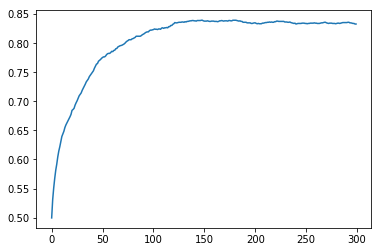

best_K = 147


In [11]:
import matplotlib.pyplot as plt

Ks=np.arange(300)
accuracy_his=[]

max_accuracy=-1
best_K=-1

for K in Ks:
    accuracy=0
    for i in range(num_val):
        u=ui_val[i]
        b=bi_val[i]
        real=y_val[i]

        nku=nearest_k_user(u,K)
        bi_list=[]
        for nu in nku:
            bi_list+=user_business[nu]

        predict=b in bi_list
        
        if predict==real:
            accuracy+=1
            
    accuracy=accuracy/num_val
    accuracy_his.append(accuracy)
    if accuracy>max_accuracy:
        max_accuracy=accuracy
        best_K=K
    if K==0 or (K+1)%50==0:
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'finished processing %d Ks' %(K+1))

accuracy_his=np.array(accuracy_his)

plt.figure(1)
plt.plot(Ks,accuracy_his)
plt.show()
print('best_K =',best_K)

In [12]:
true_pos=0
true_neg=0
false_pos=0
false_neg=0

for i in range(num_val):
    u=ui_val[i]
    b=bi_val[i]
    real=y_val[i]

    nku=nearest_k_user(u,best_K)
    bi_list=[]
    for nu in nku:
        bi_list+=user_business[nu]

    predict=b in bi_list
        
    if predict==1 and real==1:
        true_pos+=1
    elif predict==1 and real==0:
        false_pos+=1
    elif predict==0 and real==1:
        false_neg+=1
    elif predict==0 and real==0:
        true_neg+=1
print('accuracy =',(true_pos+true_neg)/num_val)
print('true pos =',true_pos)
print('false pos =',false_pos)
print('false neg =',false_neg)
print('true neg=',true_neg)
pp=true_pos/(true_pos+false_pos)
rr=true_pos/(true_pos+false_neg)
print('F1 =',(2.0*pp*rr)/(pp+rr))

accuracy = 0.8395
true pos = 760
false pos = 80
false neg = 241
true neg= 919
F1 = 0.8256382400869094


In [17]:
test_file=open('data/pairs_Visit.txt')
fo=open('data/pairs_Visit_out3.txt','w')
fo.write('userID-businessID,prediction\n')
c1=0
c2=0
c3=0
for line in test_file:
    if line == 'userID-businessID,prediction\n':
        continue
    [u,b]=line.strip().split('-')
    if u not in user_index or b not in buss_index:
        predict=random.randint(0,1)
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c1+=1
    elif buss_index[b] in user_business[user_index[u]]:
        fo.write('%s-%s,1\n' %(u,b))
        c2+=1
    else:
        ui=user_index[u]
        bi=buss_index[b]

#         nku=nearest_k_user(ui,best_K)
        nku=nearest_k_user(ui,300)
        bi_list=[]
        for nu in nku:
            bi_list+=user_business[nu]

        predict=bi in bi_list
                
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c3+=1
fo.close()
print(c1,c2,c3)

63 11 39926
